# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Analyse Strategy Performance

In this notebook, you will learn to analyse the performance of the strategy using various performance metrics.

## Create a Long Short Strategy

In [1]:
# Data analysis and manipulation
import pandas as pd
import numpy as np
import quandl
import quandl.api_config
import quandl.get_table
import talib as ta
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')


#quandl.ApiConfig.api_key='YOUR_API'
stock_data = quandl.get("BITFINEX/BTCUSD",authtoken="4KPQ9Y6_ND3VNqyfi7xc", start_date="2017-08-16", end_date="2022-11-03", index_col=0)

# Set the index to datetime
stock_data.index = pd.to_datetime(stock_data.index)
stock_data.head()


# Set the index to datetime
stock_data.index = pd.to_datetime(stock_data.index)

# Calculate the parabolic SAR
stock_data['SAR'] = ta.SAR(stock_data['High'].values, stock_data['Low'].values,
                           acceleration=0.02, maximum=0.2)

# Calculate the stochastic oscillator
stock_data['slowk'], stock_data['slowd'] = ta.STOCH(stock_data['High'].values, stock_data['Low'].values,
                                                    stock_data['Last'].values, fastk_period=5, slowk_period=3, slowd_period=3)


stock_data['fastk'], stock_data['fastd'] = ta.STOCHF(stock_data['High'].values, stock_data['Low'].values,
                                                     stock_data['Last'].values, fastk_period=5, fastd_period=3)

# Column to store trading signals
stock_data['signal'] = np.nan


# Buy signal
stock_data.loc[(stock_data['SAR'] < stock_data['Last']) & (stock_data['fastd'] > stock_data['slowd'])
               & (stock_data['fastk'] > stock_data['slowk']), 'signal'] = 1

# Sell signal
stock_data.loc[(stock_data['SAR'] > stock_data['Last']) & (stock_data['fastd'] < stock_data['slowd'])
               & (stock_data['fastk'] < stock_data['slowk']), 'signal'] = -1

# Fill the missing values with last valid observation
stock_data = stock_data.fillna(method = 'ffill')

# Calculate the stock returns
stock_data['stock_returns'] = stock_data['Last'].pct_change()

# Calculate the strategy returns
stock_data['strategy_returns'] = (
    stock_data['stock_returns'] * stock_data['signal'].shift(1))

# Drop the NaN values
stock_data = stock_data.dropna()

# Calculate the total cost
transaction_cost = 0.001
slippage_cost = 0.0022
total_cost = transaction_cost + slippage_cost

# Calculate the trading cost when you square off the position
trading_cost = (total_cost * np.abs(stock_data.signal -
                                    stock_data.signal.shift(1)))

# Calculate the net strategy returns
stock_data['strategy_returns_minus_cost'] = stock_data['strategy_returns'] - trading_cost

# Calculate the cumulative strategy returns
cum_strategy_returns = ((stock_data['strategy_returns_minus_cost'] + 1).cumprod())

<a id='strategy_performance'></a>
## Analyse Strategy Performance

### Plot Cumulative Strategy Returns

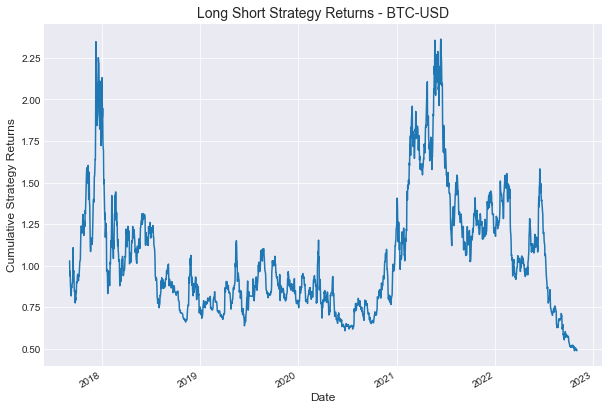

In [18]:
def plot_strategy_returns(cumulative_strategy_returns, title):

    # Plot the cumulative strategy returns
    plt.figure(figsize=(10, 7))
    cumulative_strategy_returns.plot()

    # Set the title of the figure
    plt.title(title, fontsize=14)

    # Set the labels for x-axis and y-axis
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Strategy Returns', fontsize=12)

    plt.show()


plot_strategy_returns(cum_strategy_returns, 'Long Short Strategy Returns - BTC-USD')

### Calculate Total/Absolute Returns

In [3]:
total_returns = (cum_strategy_returns.iloc[-1]-1)*100

print('The total returns of strategy is %.2f' % total_returns + '%')

The total returns of strategy is -50.82%


### Calculate Annualised Returns

The annual returns are returns that the investment has earned over one year.

In [4]:
# Total number of trading days
days = len(cum_strategy_returns)

# Calculate the compounded annual growth rate
cagr = (cum_strategy_returns.iloc[-1]**(252/days)-1)*100
print('The CAGR of strategy is %.2f' % cagr + '%')

The CAGR of strategy is -9.16%


### Sharpe Ratio
The Sharpe ratio is the excess returns per unit of volatility. Excess return is the total returns minus the risk-free rate of return. Generally, risk-free return is the return on the risk-free assets, such as government bonds. 

In [5]:
# Assume that an average annual risk-free rate is 1%
risk_free_rate = 0.04/252

sharpe = np.sqrt(252)*(np.mean(stock_data.strategy_returns) -
                       (risk_free_rate))/np.std(stock_data.strategy_returns)
print("The Sharpe ratio of strategy is %.2f" % sharpe)

The Sharpe ratio of strategy is 0.29


### Maximum Drawdown
Maximum drawdown measures the peak-to-trough decline in the value of the portfolio and is quoted as the percentage of the peak value.

In [6]:
def calc_drawdown(cum_rets):

    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())

    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1

    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1

    # Calculate the maximum drawdown
    max_dd = drawdown.min()*100

    return drawdown, max_dd


drawdown, max_dd = calc_drawdown(cum_strategy_returns)

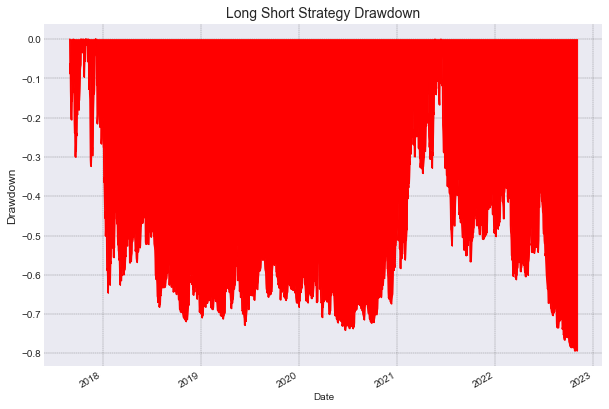

The maximum drawdown of strategy is -79.34%


In [7]:
def plot_drawdown(drawdown, title):

    # Plot the drawdown
    plt.figure(figsize=(10, 7))
    drawdown.plot(color='r')
    plt.ylabel('Drawdown', fontsize = 12)
    plt.title(title, fontsize=14)
    plt.fill_between(drawdown.index, drawdown.values, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()


plot_drawdown(drawdown,'Long Short Strategy Drawdown')

print("The maximum drawdown of strategy is %.2f" % max_dd + '%')

---

## Create a Long Only Strategy

In [9]:
# Column to store new trading signals
stock_data['new_signal'] = np.nan


# Buy signal
stock_data.loc[(stock_data['SAR'] < stock_data['Last']) & (stock_data['fastd'] > stock_data['slowd'])
               & (stock_data['fastk'] > stock_data['slowk']), 'new_signal'] = 1

# Exit signal
stock_data.loc[(stock_data['SAR'] > stock_data['Last']) & (stock_data['fastd'] < stock_data['slowd'])
               & (stock_data['fastk'] < stock_data['slowk']), 'new_signal'] = 0

# Fill the missing values with last valid observation
stock_data = stock_data.fillna(method = 'ffill')

# Calculate the strategy returns
stock_data['new_strategy_returns'] = (
    stock_data['stock_returns'] * stock_data['new_signal'].shift(1))

# Calculate the net strategy returns
stock_data['new_strategy_returns_minus_cost'] = stock_data['new_strategy_returns'] - trading_cost

# Drop the NaN values
stock_data = stock_data.dropna()

# Calculate and plot the cumulative strategy returns
new_cum_strategy_returns = (stock_data['new_strategy_returns_minus_cost']+1).cumprod()

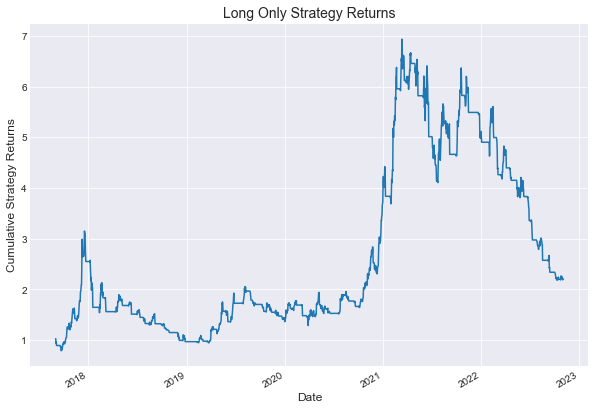

In [10]:
# Plot the cumulative strategy returns
plot_strategy_returns(new_cum_strategy_returns, 'Long Only Strategy Returns')

In [11]:
# Calculate the total/absolute returns
new_total_returns = (new_cum_strategy_returns.iloc[-1]-1)*100

print('The total returns of strategy is %.2f' % new_total_returns + '%')

The total returns of strategy is 120.28%


In [12]:
# Calculate the compounded annual growth rate
new_cagr = (new_cum_strategy_returns.iloc[-1]**(252/days)-1)*100
print('The CAGR of strategy is %.2f' % new_cagr + '%')

The CAGR of strategy is 11.28%


In [13]:
# Calculate the Sharpe ratio
new_sharpe = np.sqrt(252)*(np.mean(stock_data.new_strategy_returns) -
                           (risk_free_rate))/np.std(stock_data.new_strategy_returns)
print("The Sharpe ratio of strategy %.2f" % new_sharpe)

The Sharpe ratio of strategy 0.64


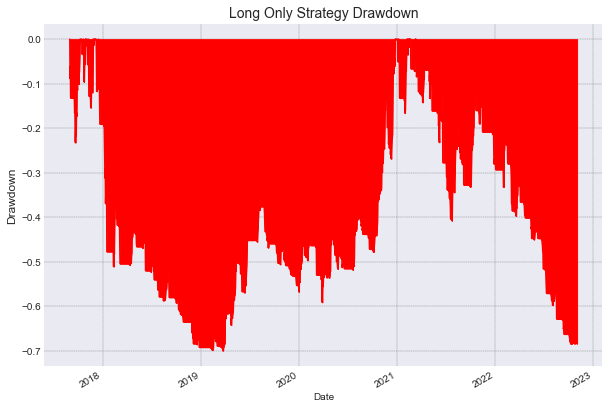

The maximum drawdown of strategy is -70.02%


In [14]:
# Calculate the drawdown
new_drawdown, new_max_dd = calc_drawdown(new_cum_strategy_returns)
plot_drawdown(new_drawdown, 'Long Only Strategy Drawdown')
print("The maximum drawdown of strategy is %.2f" % new_max_dd + '%')


## Performance Summary

In [17]:
# Import the tabulate
from tabulate import tabulate

stats = tabulate(
        [
            ['Strategy Returns', new_total_returns],
            ['Sharpe', new_sharpe],
            ['CAGR', new_cagr],
            ['Maximum Drawdown', new_drawdown.min()*100]
    
        ],
        headers=['Stats Name', 'Long Only Strategy'], tablefmt='orgtbl')

print(stats)

| Stats Name       |   Long Only Strategy |
|------------------+----------------------|
| Strategy Returns |           120.279    |
| Sharpe           |             0.637414 |
| CAGR             |            11.2801   |
| Maximum Drawdown |           -70.0222   |
